# RoC Analysis

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

In [72]:
no_predictors = 2
no_samples = 1000
no_classes = 2

import numpy as np
import matplotlib.pyplot as plt


# Generate random data with intercept
np.random.seed(0)
#beta_star = np.random.randn(no_predictors + 1)  # Add 1 for the intercept
#beta_star = beta_star / np.linalg.norm(beta_star)
#non random beta_star
beta_star = np.array([2, 1, 1])
X = np.random.randn(no_samples, no_predictors)
X = np.concatenate((np.ones((no_samples, 1)), X), axis=1) # Add intercept column
y = np.random.binomial(1, 1 / (1 + np.exp(-X @ beta_star)))

# Split into training and test data
n_train = int(no_samples * 0.8)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]


## Plots

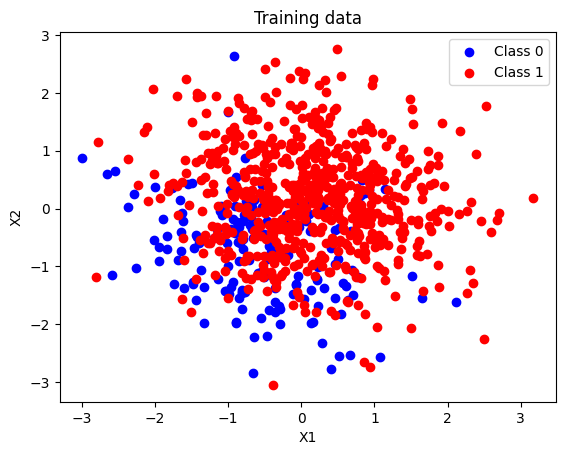

In [73]:
# Plot the training data
plt.figure()
plt.scatter(X_train[y_train == 0, 1], X_train[y_train == 0, 2], color='b', label='Class 0') #Corrected indexing
plt.scatter(X_train[y_train == 1, 1], X_train[y_train == 1, 2], color='r', label='Class 1') #Corrected indexing
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Training data')
plt.show()

## Logistic regression

In [74]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)
beta_hat = clf.coef_[0]
beta_hat = beta_hat / np.linalg.norm(beta_hat)

print('True beta: ', beta_star)
print('Estimated beta: ', beta_hat)
print('Mean squared error: ', np.mean((beta_star - beta_hat) ** 2))

True beta:  [2 1 1]
Estimated beta:  [0.76941238 0.39001275 0.50586029]
Mean squared error:  0.7102014575432795


## Standard RoC curve

In [75]:
# Plot the RoC curve
from sklearn.metrics import roc_curve
fpr_roc, tpr_roc, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])


## RoC curve by cost-sensitive learning

The following function fixes the threshold value. The input model to the function will be weighted in order to have the bias towards the minority class

In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero

        return {"fpr": fpr, "tpr": tpr}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [77]:
# Test the function
threshold = 0.5
result = get_fpr_tpr(clf, X_test, y_test, threshold=threshold)
print(f"FPR: {result['fpr']:.3f}, TPR: {result['tpr']:.3f} at threshold {threshold}")

threshold = 0.7
result = get_fpr_tpr(clf, X_test, y_test, threshold=threshold)
print(f"FPR: {result['fpr']:.3f}, TPR: {result['tpr']:.3f} at threshold {threshold}")

FPR: 0.514, TPR: 0.957 at threshold 0.5
FPR: 0.216, TPR: 0.871 at threshold 0.7


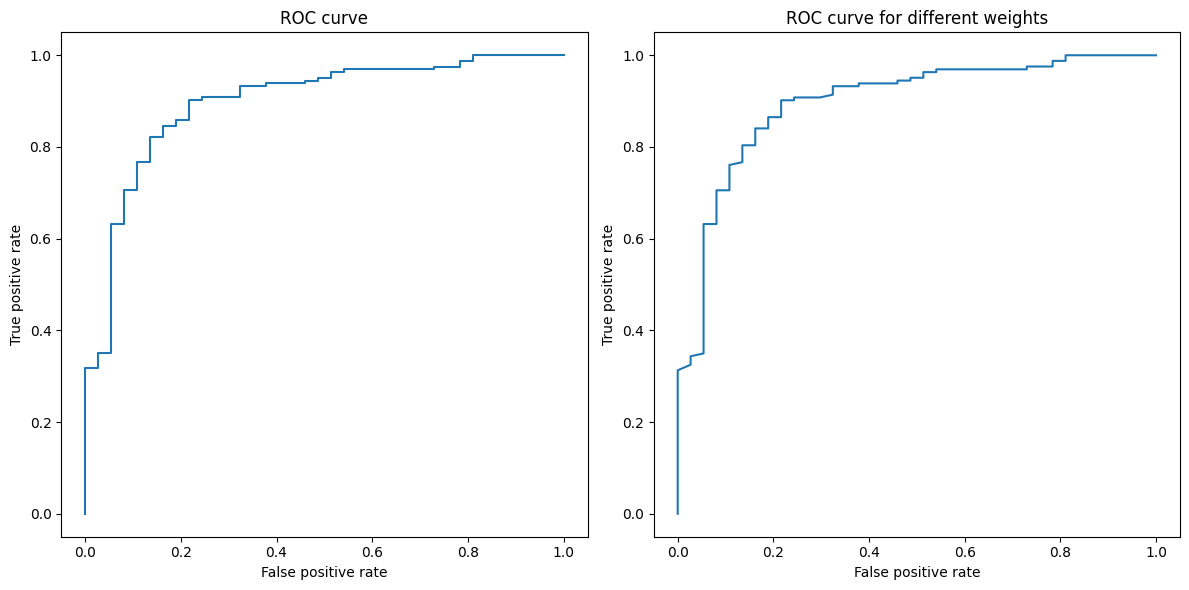

In [78]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0.001, 0.999, 0.001)
majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    class_weights = {0: 1 - w, 1: w}

    clf_weighted = LogisticRegression(fit_intercept=False, class_weight=class_weights)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(fpr_roc, tpr_roc)
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve')
ax[1].plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()])
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve for different weights')


plt.tight_layout()
plt.show()


## Conclusion

* 1. For the simple logistic regression function, the RoC curve either generated by changing the threshold or by changing the weights generate similar results.
* 2. Changing weights take longer to execute